# $\beta$ - $r$ Hypothesis
During the manouvres in the MDL data, such as zigzag and turning circle tests, drift angle $\beta$ is always accompanied by the yaw rate $r$ -- the ship cannot experience only a drift angle during these manoeuvres. When the ship is exposed to wind forces is another matter. At wind, the ship can have only a drift angle without a yaw rate. 
This is possibly a new situation which the model, trained on MDL data has never been exposed to before.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[08/16/23 16:15:20] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=906828;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=687998;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/16/23 16:15:30] INFO     Kedro project phd                                                      ]8;id=300893;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=341870;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=548363;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=209179;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=668647;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=401621;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=546000;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459300;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=903773;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=835726;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=622;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=235441;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=427426;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=281744;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=774200;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160173;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=567753;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=631155;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
time_series_MDL = catalog.load(f"wPCC.time_series")
time_series_smooth_MDL = catalog.load(f"wPCC.time_series_preprocessed.ek_smooth")

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=540117;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=514695;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=749391;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=203590;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

In [5]:
data_MDL = time_series_smooth_MDL['wpcc.updated.joined.ek_smooth']()
data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
data_MDL['beta_deg'] = np.rad2deg(data_MDL['beta'])

In [6]:
_ = []
for id, loader in time_series.items():
    df_ = loader()
    df_['id'] = str(id)
    _.append(df_)
    
data_all = pd.concat(_)
data_all.set_index("global time", inplace=True)
assert data_all.index.is_unique
data_all.sort_index(inplace=True)
data_all['trip_no'] = data_all['id'].astype(int)
data_all['beta'] = smallest_signed_angle(data_all['beta'])
data_all['beta_deg'] = np.rad2deg(data_all['beta'])

In [7]:
def mean(df:pd.DataFrame, units:dict):
    
    means = df.select_dtypes(exclude='object').mean()
    
    for key, unit in units.items():
        if unit == "rad":
            means[key] = mean_angle(df[key])
            
    return means

In [8]:
def rolling_mean(data_all, window=10):
    data_ = data_all.select_dtypes(exclude='object').rolling(window=window).mean().dropna()
    for key,values in data_.items():
        unit = units.get(key,'')
        if unit=='rad':
            data_[key] = mean_angle(data_all[key])
            
    return data_
            

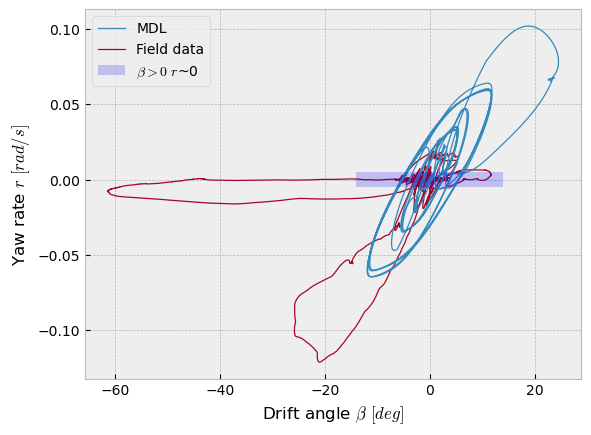

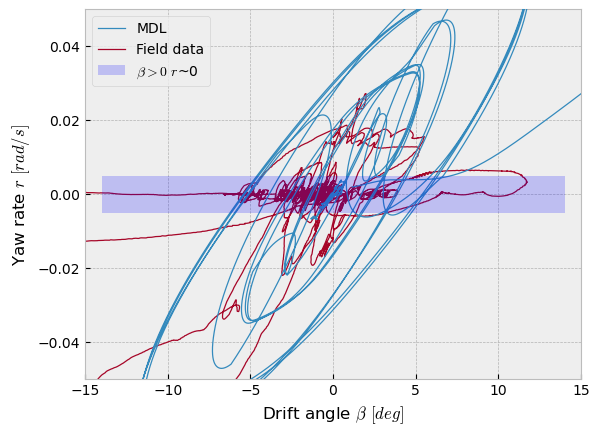

In [9]:
from matplotlib.patches import Rectangle

data_ = rolling_mean(data_all, window=1000)
data_['beta'] = smallest_signed_angle(-np.arctan2(data_['v'],data_['u']))
data_['beta_deg'] = np.rad2deg(data_['beta'])


data_MDL_ = data_MDL.rolling(window=1000).mean()
data_MDL_['beta'] = -np.arctan2(data_MDL_['v'],data_MDL_['u'])
data_MDL_['beta_deg'] = np.rad2deg(data_MDL_['beta'])

fig,ax=plt.subplots()
data_MDL_.plot(x='beta_deg', y='r', label='MDL', ax=ax, style='-', alpha=1, lw=0.9, zorder=10)
data_.plot(x='beta_deg', y='r', label='Field data', ax=ax, style='-', lw=0.9, alpha=1)
ax.add_patch(Rectangle((-14, -0.005), 28, 0.01, zorder=20, alpha=0.2, label=r'$\beta > 0$ $r$~0'))
ax.set_xlabel(r'Drift angle $\beta$ $[deg]$');
ax.set_ylabel(r'Yaw rate $r$ $[rad/s]$');
ax.legend()


fig,ax=plt.subplots()
data_MDL_.plot(x='beta_deg', y='r', label='MDL', ax=ax, style='-', alpha=1, lw=0.9, zorder=10)
data_.plot(x='beta_deg', y='r', label='Field data', ax=ax, style='-', lw=0.9, alpha=1)
ax.add_patch(Rectangle((-14, -0.005), 28, 0.01, zorder=20, alpha=0.2, label=r'$\beta > 0$ $r$~0'))

ax.set_xlim(-15,15);
ax.set_ylim(-0.05,0.05);
ax.set_xlabel(r'Drift angle $\beta$ $[deg]$');
ax.set_ylabel(r'Yaw rate $r$ $[rad/s]$');
ax.legend()


In [10]:
mask = ((data_MDL['beta'] > np.deg2rad(5)) & (data_MDL['r'].between(-0.001,0.001)))
data_MDL_select = data_MDL.loc[mask].copy().sort_index()
#stop = (data_MDL_select['time'].diff() > 0.10).idxmax()
stop = np.argmax(np.diff(data_MDL_select.index)>1)
data_MDL_select=data_MDL_select.iloc[0:stop]

data_MDL_select_surrounding = data_MDL.loc[data_MDL_select.index[0]-1000:data_MDL_select.index[0]+1000]

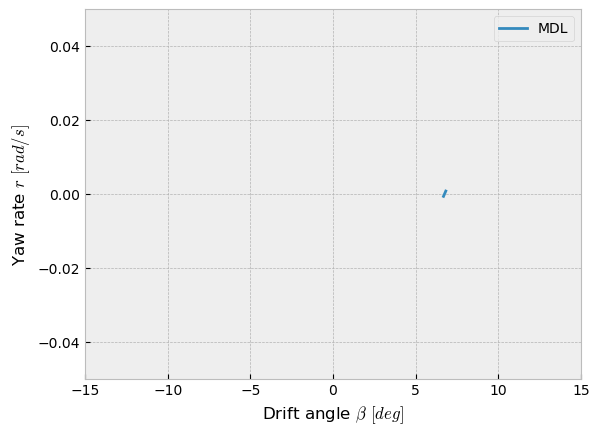

In [11]:
fig,ax=plt.subplots()
data_MDL_select.plot(x='beta_deg', y='r', label='MDL', ax=ax, style='-', alpha=1, zorder=10)
ax.set_xlim(-15,15);
ax.set_ylim(-0.05,0.05);
ax.set_xlabel(r'Drift angle $\beta$ $[deg]$');
ax.set_ylabel(r'Yaw rate $r$ $[rad/s]$');

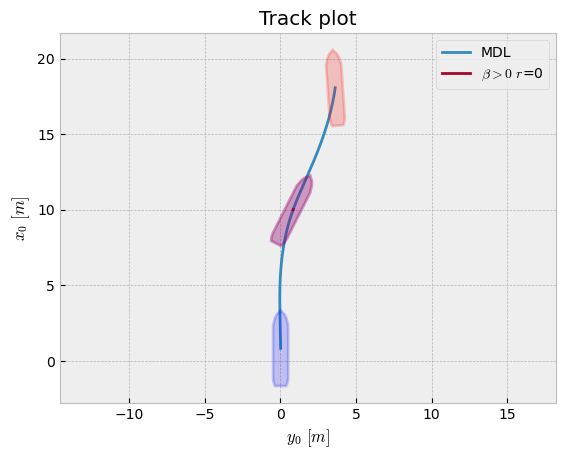

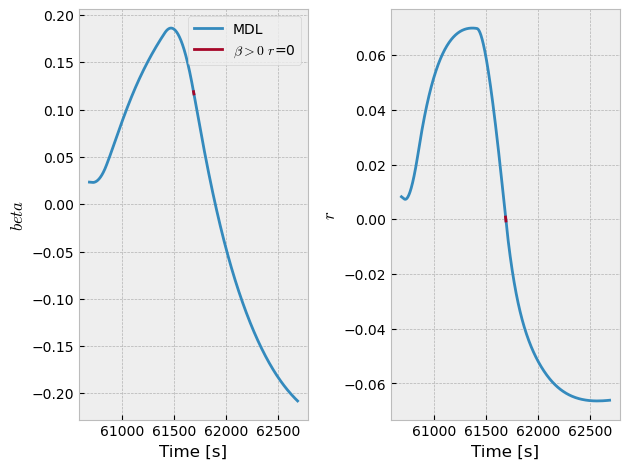

In [12]:
dataframes = {
'MDL' : data_MDL_select_surrounding,
r'$\beta > 0$ $r$=0' : data_MDL_select
}
track_plots(dataframes, lpp=5, beam=1, N=2)
plot(dataframes, keys=['beta','r']);

## Conclusions
The situation with drift angle and no yaw rate does in fact appear during the zigzag manoeuvre - at one occation per turn - in the zero crossing of the yaw rate. But is this enough data to have a good represenation of this situation? This situation is quite frequent in the field data.

## Further work
- [ ] Fit a model on the VCT data instead, which will have a better drift angle represenation.